# Using Python to analyze Billboard Top 100 pop songs 

### Introduction and Background

There is a common sentiment that songs in recent years are getting more negative or are "not as good as they used to be." This poses a question of interest: is that the most distintive feature of popular songs that stayed constant throughout the past 50 years? This is important because we can see how pop songs get their popularity based on a distinctive feature over changing times. 
Some relevant prior work and references include the python package nltk, and sentiwordnet (an analysis on the sentiment of words), and an article on song reptition. 

These observations led us to ask the following research question: How does the sentiment value of pop song lyrics correlate with their rankings over time?

We believe that sentiment of song lyrics is strongly correlated with their respective Billboard rankings over a period from 1965 to 2015. In other words, sentiment is a defining feature of popularity of pop songs over the past 50 years.


References:
- 1) https://pudding.cool/2017/05/song-repetition/

This project analyzed the repetitiveness of pop songs throughout the years. It gave us some insight on how this certain feature of a song can determine its popularity through time. They found that pop songs were, in fact, getting more repetitive since 1960. In our case, we want to specifically analyze the words and their connotations to see if they are the defining feature of the song's popularity. 
- 2) http://sentiwordnet.isti.cnr.it/

With SentiWordNet, we are able to assign a quantitative sentiment values to songs to measure their popularity growth. We are planning to run a song's entire lyrics through the sentiment analyzer.

## Data Collection and Description

### Billboard

- Dataset Name: Billboard 1964-2015 Songs + Lyrics
- Link to the dataset: https://www.kaggle.com/rakannimer/billboard-lyrics/downloads/billboard-1964-2015-songs-lyrics.zip
- Number of observations: 5101

This dataset includes all the songs on the top 100 Billboard list from 1964 - 2015. The data provided includes the Rank, Song name, Artist, Year, and Lyrics.

In [1]:
# Import modules 
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind
from numpy.random import rand
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import the data from billboard (CSV)
billboard_df = pd.read_csv('billboard_data.csv', sep=',', encoding='latin-1')
billboard_df.head(10)

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1.0
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,3.0
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,5.0
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,1.0
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,3.0


In [3]:
print(billboard_df.shape)

(5100, 6)


### Sentiword

Dataset Name: Sentiword
- Link to the dataset: http://sentiwordnet.isti.cnr.it/
- Number of observations: 100,000+

This dataset includes words and the word's relative sentiment score on a positive/negative scale.


In order to process the sentiment data, we need to first install the package nltk (Natural Language Took Kit), a package for building Python programs to work with human language data. With this, we can analyze the sentiment value of the lyrics of each song.

In [4]:
!pip install nltk

In [5]:
# Import the data for sentiword (sentiment analysis)
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

C:\Users\vivia\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### NEED TO UNCOMMENT BELOW CODE AND DOWNLOAD NLTK PACKAGE FOR SENTIMENT ANALYZER TO WORK. MAY TAKE A LONG WHILE TO DOWNLOAD

In [6]:
# nltk.download()

## Data Cleaning and Pre-Processing

By initially looking at the data, we saw that the 'Source' column was going to be irrelevant for our data analysis. To keep things clean and efficient, we decided to simply drop the whole column.

In [7]:
# Dropping 'Source' column
billboard_df.drop(['Source'], inplace=True, axis=1)

Additionally, we found that some songs in the data set had no lyrics for whatever reason. We decided to omit these songs from our lyric analysis. 

But how do we check if a song has no lyrics? We manually looked through our data set and found that some "empty" lyric cells contained "  ", "NA ", " NA " or NaN. So we decided to drop all the cells in the Lyrics column that contained any of those values. 

In [8]:
# Replace every occurrence of '' with NaN
billboard_df['Lyrics'].replace('', np.nan, inplace=True)
# Replace every occurance of "  " with NaN
billboard_df['Lyrics'].replace('  ', np.nan, inplace=True)
# Replace every occurance of "NA " with NaN
billboard_df['Lyrics'].replace('NA ', np.nan, inplace=True)
# Replace every occurance of " NA " with NaN
billboard_df['Lyrics'].replace(' NA ', np.nan, inplace=True)

# Drop all NaN values
billboard_df.dropna(subset=['Lyrics'], inplace=True)

print(billboard_df.shape)

(4852, 5)


Note: We can see that the original df had 5100 rows, but after dropping the rows with no lyrics, we now have 4852 rows.

### Remove all non-alphanumeric characters from all lyrics

We also deleted non-alphanumeric characters in the lyrics, as they do not add any significance to analyzing a word's sentiment. 

In [9]:
#Deleting all non-alphanumeric characters in all lyrics
import re

for i in range( len(billboard_df) ) :
    lyrics = billboard_df.loc[billboard_df.index[i],'Lyrics'] 
    #Here we use a regex to specify only that alphanumeric characters should be kept
    newlyrics = re.sub(r'\W+', ' ', lyrics)
    billboard_df.loc[billboard_df.index[i],'Lyrics'] = newlyrics


### Removing repeating words from Lyrics
We also decided to create a copy of the billboard_df called billboard_df2 which does not have any repeated lyrics. We are going to run the sentiment analyzer on both dataframes to compare the results, and see if repeated lyrics/words affect the trend.

### Sentiment Analyzer

Four new columns will be added to the dataframe to record the sentiment scores obtained by processing each song's lyrics through the sentiment analyzer. The scores used will be 'Compound', 'Positive', 'Negative', and 'Neutral' to sum up the overal sentiment value of each song.

In [10]:
billboard_df["Compound"] = np.nan
billboard_df["Positive"] = np.nan
billboard_df["Negative"] = np.nan
billboard_df["Neutral"] = np.nan

In [37]:
#Creating copy of dataframe
billboard_df2 = billboard_df.copy(deep=True) 

#Function used to delete repeated words
def delete_repeats(l):
    aggregate = []
    [aggregate.append(x) for x in l if x not in aggregate]
    #Once we have the aggregated list of words, we reform the lyrics by respacing out the words and joining them
    non_repeats = ' '.join(aggregate)
    return non_repeats
 
for i in range( len(billboard_df2) ) :
    lyrics = billboard_df2.loc[billboard_df2.index[i],'Lyrics'] 
    newlyrics = delete_repeats(lyrics.split())
    billboard_df2.loc[billboard_df2.index[i],'Lyrics'] = newlyrics
    

Here, we are running sentiment analysis on original dataframe. 

In [12]:
for i in billboard_df.index.tolist():
    lyric = billboard_df.loc[i]['Lyrics']
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(lyric)
    billboard_df.set_value(i, 'Compound', ss['compound'])
    billboard_df.set_value(i, 'Negative', ss['neg'])
    billboard_df.set_value(i, 'Positive', ss['pos'])
    billboard_df.set_value(i, 'Neutral', ss['neu'])
    
billboard_df

,Rank,Song,Artist,Year,Lyrics,Compound,Positive,Negative,Neutral
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,-0.9946,0.020,0.352,0.628
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,0.2624,0.137,0.159,0.704
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,-0.9607,0.061,0.186,0.754
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,0.9958,0.266,0.085,0.649
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,0.9249,0.165,0.133,0.702
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,0.9937,0.260,0.072,0.669
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,0.9885,0.150,0.000,0.850
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,0.9911,0.289,0.077,0.634
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,0.9500,0.133,0.013,0.854
10,11,help me rhonda,the beach boys,1965,well since she put me down i ve been out doin ...,0.9997,0.526,0.009,0.465


Then, we are running the same analysis on the dataframe with no repeated words/lyrics. 

In [13]:
#doing sentiment analysis on billboard_df2

for i in billboard_df2.index.tolist():
    lyric = billboard_df2.loc[i]['Lyrics']
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(lyric)
    billboard_df2.set_value(i, 'Compound', ss['compound'])
    billboard_df2.set_value(i, 'Negative', ss['neg'])
    billboard_df2.set_value(i, 'Positive', ss['pos'])
    billboard_df2.set_value(i, 'Neutral', ss['neu'])
    
billboard_df2

,Rank,Song,Artist,Year,Lyrics,Compound,Positive,Negative,Neutral
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully pharaoh...,-0.4122,0.049,0.076,0.875
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love can...,-0.0325,0.112,0.094,0.794
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my min...,-0.5994,0.093,0.171,0.736
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss ...,0.8381,0.205,0.123,0.673
5,6,downtown,petula clark,1965,when youre alone and life is making you lonely...,0.8306,0.210,0.166,0.624
6,7,help,the beatles,1965,help i need somebody not just anybody you know...,0.5035,0.122,0.072,0.807
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,0.8834,0.133,0.000,0.867
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel tears i shed w...,0.9826,0.348,0.081,0.571
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,0.8857,0.197,0.031,0.773
10,11,help me rhonda,the beach boys,1965,well since she put me down i ve been out doin ...,-0.1197,0.096,0.059,0.845


## Data Visualization 

### Attempt 1: Scatterplot of all song's sentiment
At first, we tried to see if we could spot a trend by simply plotting all the lyric's sentiments over time. This, however, did not reveal much because most songs seem to cluster around +/- 1. 

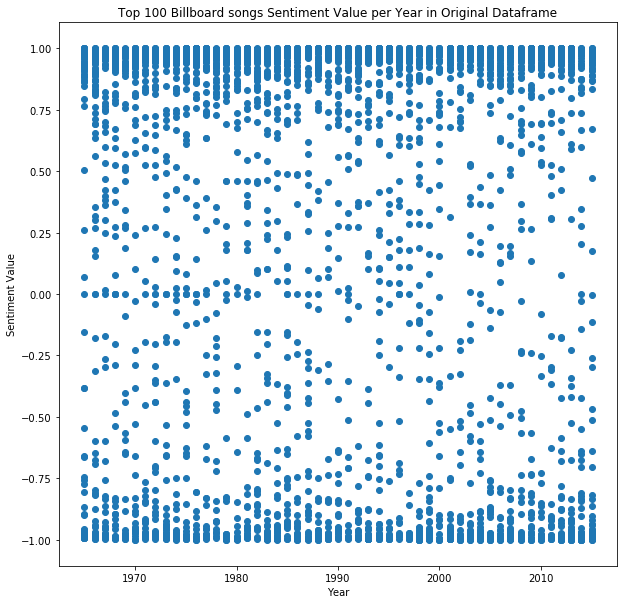

In [14]:
# Scatter plot of all sentiment on original dataframe
all_compound_df = billboard_df[['Year', 'Compound']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df['Year'], all_compound_df['Compound'])
plt.ylabel('Sentiment Value')
plt.xlabel('Year')
plt.title('Top 100 Billboard songs Sentiment Value per Year in Original Dataframe')

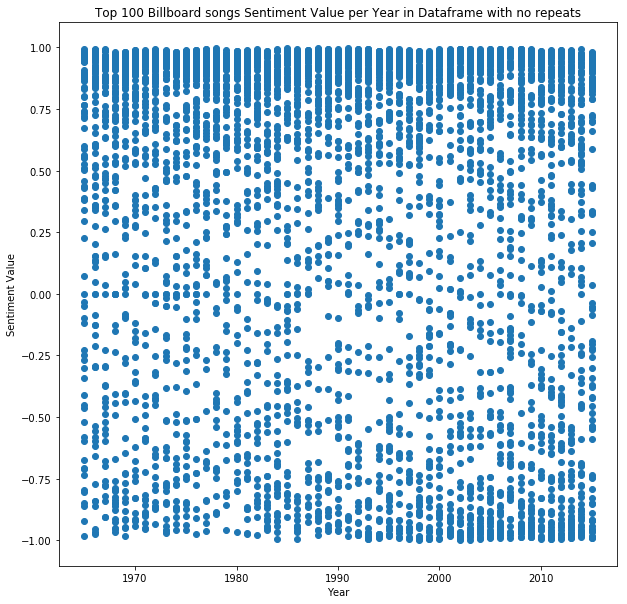

In [15]:
# Scatter plot of all sentiment on dataframe 2
all_compound_df2 = billboard_df2[['Year', 'Compound']]
plt.figure(figsize=(10,10))
plt.scatter(all_compound_df2['Year'], all_compound_df2['Compound'])
plt.ylabel('Sentiment Value')
plt.xlabel('Year')
plt.title('Top 100 Billboard songs Sentiment Value per Year in Dataframe with no repeats')

### Attempt 2: Average sentiment over year
For our second attempt, we averaged all the songs' sentiment in a given year and plotted it by year. Here we can see somewhat of a downward trend, indicating that songs are tending to become more and more negative over the years. However, we still see that all the averages are still above 0, meaning that on average, a given year's lyrical content is positive.

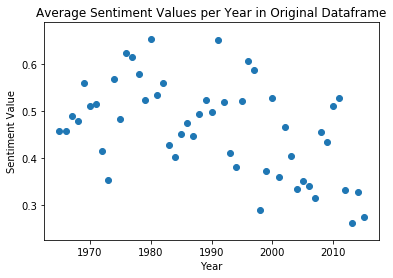

In [16]:
# Average sentiment of all songs in each year in the original dataframe
yearly_compound_df = billboard_df[['Year', 'Compound']]
yearly_compound_df = yearly_compound_df.groupby(['Year'])['Compound'].mean().to_frame()
yearly_compound_df = yearly_compound_df.reset_index(level=['Year', 'Compound'])
plt.scatter(yearly_compound_df['Year'], yearly_compound_df['Compound'])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Average Sentiment Values per Year in Original Dataframe')

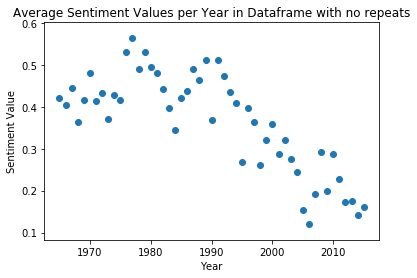

In [17]:
# Average sentiment of all songs in each year in dataframe 2
yearly_compound_df2 = billboard_df2[['Year', 'Compound']]
yearly_compound_df2 = yearly_compound_df2.groupby(['Year'])['Compound'].mean().to_frame()
yearly_compound_df2 = yearly_compound_df2.reset_index(level=['Year', 'Compound'])
plt.scatter(yearly_compound_df2['Year'], yearly_compound_df2['Compound'])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Average Sentiment Values per Year in Dataframe with no repeats')

We performed a linear regression test to find correlation between year and the lyrics' compound sentimental values.

In [18]:
# Let's perform a linear regression analysis to determine if a trend actually exists. 

outcome, predictors = patsy.dmatrices('Year ~ Compound', yearly_compound_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Year   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     15.55
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           0.000256
Time:                        14:24:54   Log-Likelihood:                -202.49
No. Observations:                  51   AIC:                             409.0
Df Residuals:                      49   BIC:                             412.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2023.8108      8.768    230.815      0.0

In [19]:
# Let's perform a linear regression analysis to determine if a trend actually exists. 

outcome, predictors = patsy.dmatrices('Year ~ Compound', yearly_compound_df2)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Year   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           5.43e-11
Time:                        14:24:54   Log-Likelihood:                -186.92
No. Observations:                  51   AIC:                             377.8
Df Residuals:                      49   BIC:                             381.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2025.3050      4.434    456.733      0.0

Based on this model, there appears to be a negative correlation between 'Compound' (the overall sentimental score of lyrics) and 'Year'. Our p-value is 0 for both tests, which is less than the alpha value of 0.05, so there is a statistical significance of the sentimental value of lyrics trending downward over the years. 

In [20]:
z = np.polyfit(x = yearly_compound_df.loc[:, 'Year'], y = yearly_compound_df.loc[:, 'Compound'], deg=1)
p = np.poly1d(z)
yearly_compound_df['trendline'] = p(yearly_compound_df.loc[:, 'Year'])

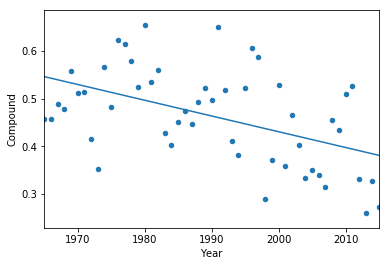

In [21]:
ax = yearly_compound_df.plot.scatter('Year', 'Compound')
yearly_compound_df.set_index('Year', inplace=True)
yearly_compound_df.trendline.sort_index(ascending=False).plot(ax=ax)
plt.gca().invert_xaxis()

Here, we plot the line of best fit. As predicted from our linear regression test, the line of best fit is y = -72.9197x + 2023.8108, and has a slope of -72.9197, which indicates a negative trend. Our correlation coefficient comes from square rooting our R-squared value, so r = -0.49091750834. 

In [22]:
z = np.polyfit(x = yearly_compound_df2.loc[:, 'Year'], y = yearly_compound_df2.loc[:, 'Compound'], deg=1)
p = np.poly1d(z)
yearly_compound_df2['trendline'] = p(yearly_compound_df2.loc[:, 'Year'])

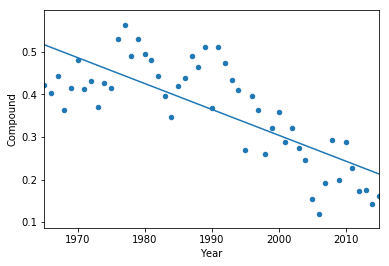

In [23]:
ax = yearly_compound_df2.plot.scatter('Year', 'Compound')
yearly_compound_df2.set_index('Year', inplace=True)
yearly_compound_df2.trendline.sort_index(ascending=False).plot(ax=ax)
plt.gca().invert_xaxis()

For this graph, the line of best fit is y = -96.6214x + 2025.2665, and has a slope of -96.6214, which indicates a negative trend as well. The correlation coefficient is r = -0.7668115805. 

### Attempt 3: Grouping by Rank
This time, we plotted the sentiment of each rank 1 song over year. We can see that most songs are very positive, sitting at between 0.75 and 1. However, we also see many songs hovering near -1 as well. This could probably be explained by looking at the lyrical structure of many songs. We see that many songs repeat the same catchy lines over and over again. So, if the SentiWordNet sees lyrics that repeat something positive, it'll start skewing the lyrics higher and higher as the song repeats those words over and over again. And likewise, a song that repeats negative lines will skew the song lower and lower.

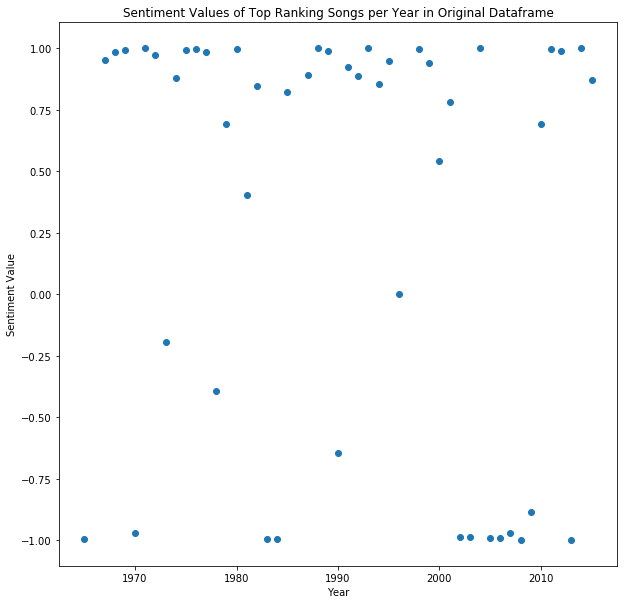

In [26]:
top1_compound_df = billboard_df[['Year', 'Compound', 'Rank']]
top1_compound_df = top1_compound_df[top1_compound_df['Rank'] == 1]
plt.figure(figsize=(10,10))
plt.scatter(top1_compound_df['Year'], top1_compound_df['Compound'])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Sentiment Values of Top Ranking Songs per Year in Original Dataframe')

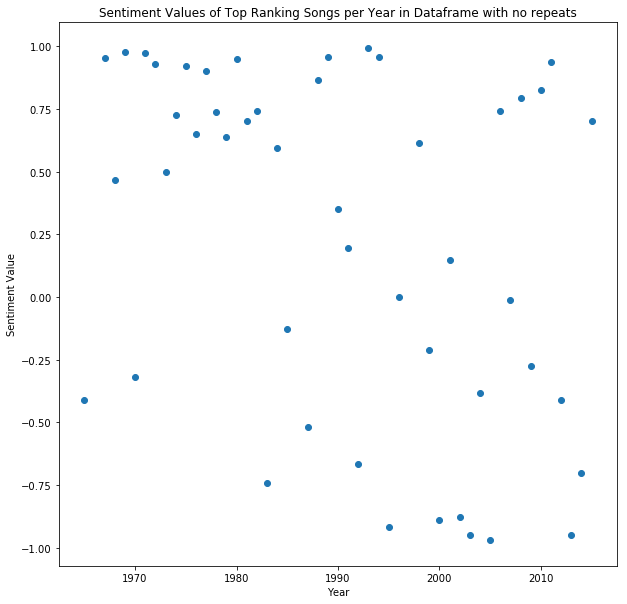

In [28]:
top1_compound_df2 = billboard_df2[['Year', 'Compound', 'Rank']]
top1_compound_df2 = top1_compound_df2[top1_compound_df2['Rank'] == 1]
plt.figure(figsize=(10,10))
plt.scatter(top1_compound_df2['Year'], top1_compound_df2['Compound'])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Sentiment Values of Top Ranking Songs per Year in Dataframe with no repeats')

### Attempt 3.1: Grouping by Rank
Here, we look at multiple rankings instead of just the first one.

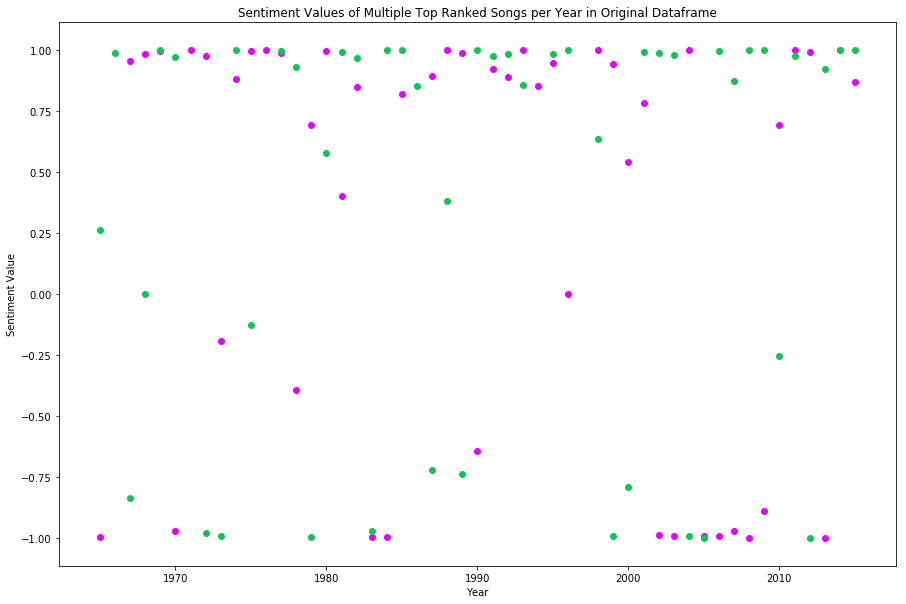

In [29]:
# Multiple scatter plots overlapped
from random import randint
colors = []
fig = plt.figure()
fig.set_size_inches(15,10)
for i in range(3):
    newColor = '%06X' % randint(0, 0xFFFFFF)
    newColor = '#' + newColor
    colors.append(newColor)
    
for i in range(3):
    x_df = billboard_df[billboard_df['Rank'] == i]
    x = x_df['Year']
    y = x_df['Compound']
    plt.scatter(x,y,c=colors[i])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Sentiment Values of Multiple Top Ranked Songs per Year in Original Dataframe')

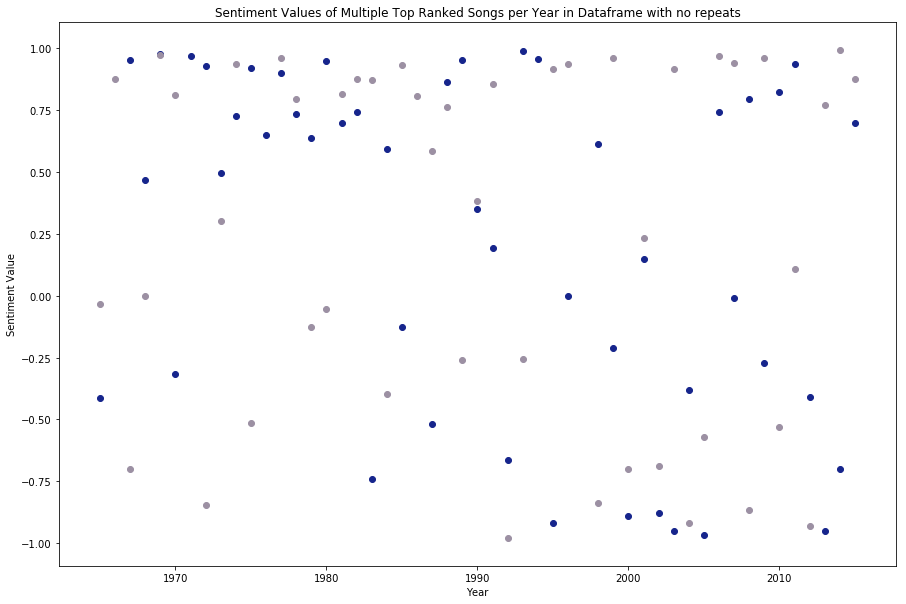

In [31]:
# Multiple scatter plots overlapped
from random import randint
colors = []
fig = plt.figure()
fig.set_size_inches(15,10)
for i in range(3):
    newColor = '%06X' % randint(0, 0xFFFFFF)
    newColor = '#' + newColor
    colors.append(newColor)
    
for i in range(3):
    x_df = billboard_df2[billboard_df2['Rank'] == i]
    x = x_df['Year']
    y = x_df['Compound']
    plt.scatter(x,y,c=colors[i])
plt.xlabel('Year')
plt.ylabel('Sentiment Value')
plt.title('Sentiment Values of Multiple Top Ranked Songs per Year in Dataframe with no repeats')

### Attempt 4: 3-D Graph

We plotted all the points in a 3D graph over the axes: x-axis is the rank, y-axis is the compound sentiment score, and z-axis as the year. From what we can tell, the graph does not show much of a correlation. There are just another visual to display our data. 

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(20,20)
for c,m in [('r', 'o')]:
    x = billboard_df['Rank']
    y = billboard_df['Year']
    z = billboard_df['Compound']
    ax.scatter(x,y,z,c=c,marker=m)
ax.set_xlabel('Rank')
ax.set_ylabel('Year')
ax.set_zlabel('Compound')
ax.title('Test')

ValueError: Unknown projection '3d'

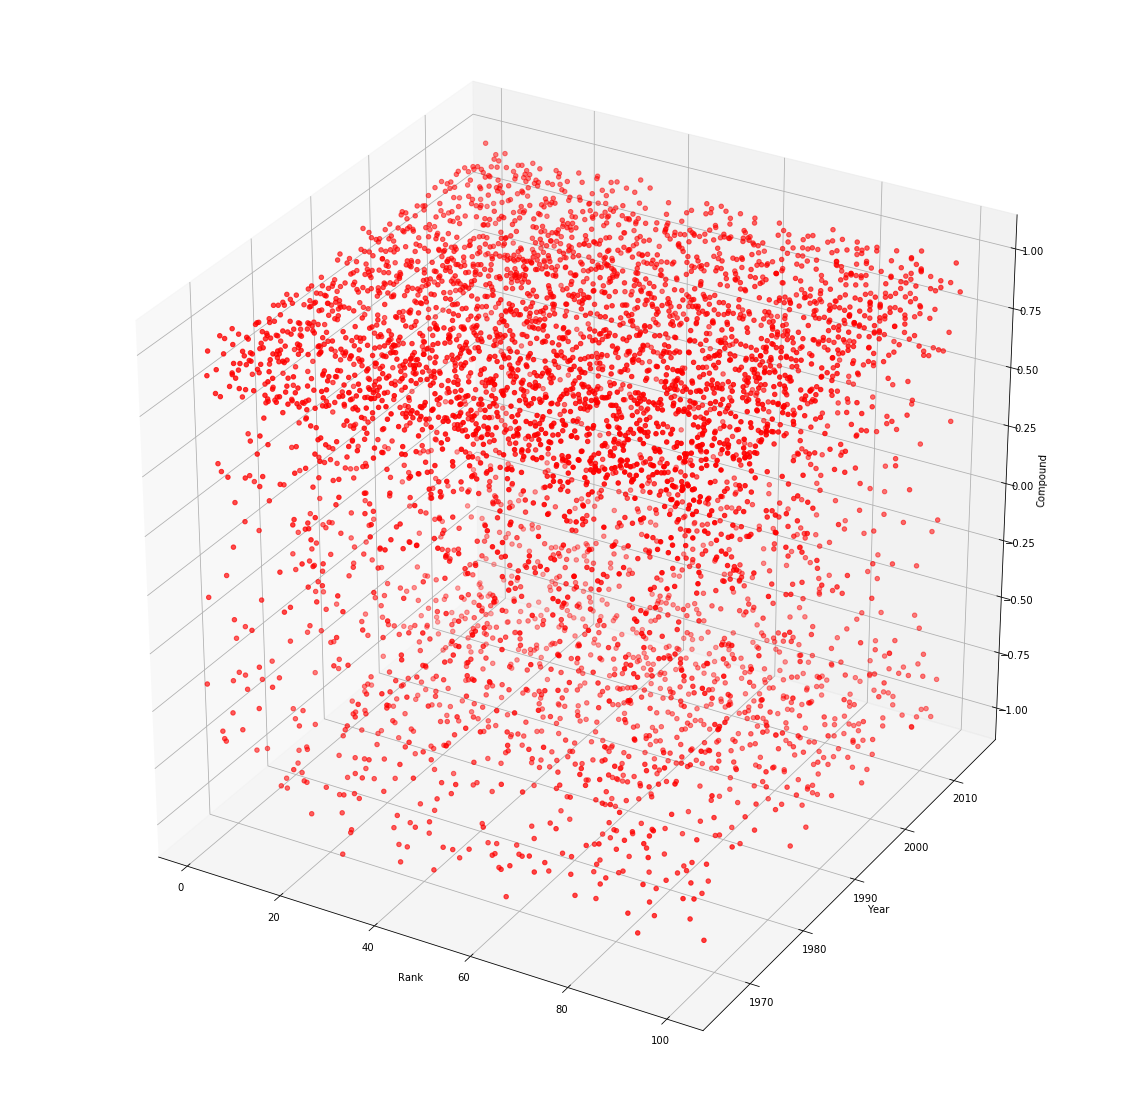

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(20,20)
for c,m in [('r', 'o')]:
    x = billboard_df2['Rank']
    y = billboard_df2['Year']
    z = billboard_df2['Compound']
    ax.scatter(x,y,z,c=c,marker=m)
ax.set_xlabel('Rank')
ax.set_ylabel('Year')
ax.set_zlabel('Compound')

## Data Analysis and Results


Firstly, in Attempt 1, we attempted to see if we could spot a trend by simply plotting all the lyric's sentiments over time. This, however, did not reveal much because most songs seemed to cluster around +/- 1. This may suggest that some songs are leaning towards extreme values of positivity or negativity. It is possible that because the lyrics of pop songs are quite repetitive, the sentiment will lean towards an extreme value of +/- 1. For example, if the chorus has a lot of repeated, positive sentiment, words, then that particular song will tend towards a sentiment value of +1 because the chorus is repeated 2-3 times during that song. 

Secondly, in Attempt 2, we simply averaged the sentiment values of the top 100 songs per year to try and discover a correlation between average sentiment and time. After averaging each year's 100 sentiment values, we applied an ordinary least squares (OLS) model to the data to determine a trendline for our data. We discovered that a weak and negative correlation was present, and that it was statistically significant (p < 0.05, r = -0.491) to support our hypothesis. It seems that over time, songs lyrics are slowly becoming less and less positive. In our analysis on the dataframe with no repeated lyrics, the correlation is stronger (r = -0.767), so even with the skew of repetition, we still need a downwards trend of sentimental score over the years. 

Lastly, in Attempt 3, we decided to take a look at only the top ranking songs per year. What we found was very similar to our findings in Attempt 1, where many years's top ranking songs tended towards a sentiment value of +/- 1. We can deduce the same results from attempt 1 in that the extreme values are due to repetitiveness of pop song lyrics. 

In Attempt 4, we tried plotting a 3D graph comparing rank, compound sentiment score, and year, but the results were inconclusive. 

From all the attempts, it seems that attempt 2 led us to find that sentiment value of pop song lyrics is weak and negatively correlated with time.

## Conclusions and Discussion

Overall, our expectations of working with this dataset were that it would be much simpler than it actually was. We assumed that the dataset we were working with would be much cleaner and consistent and we didn’t account for the many confounds of our data. Cleaning the data was by far the most time consuming part of the project. There were many inconsistencies within the data including having no lyrical data for some songs, use of slang that is not part of our Sentiword dictionary, repetition of the chorus in songs, inconsistent spacing and transcription shortcuts like [repeat chorus x2] between words and lines, songs in foreign languages, and more. 

    "...verse 1 b dm from the time i fall asleep e f til the morning comes i dream about...repeat chorus bridge rhythm guitar plays muted 18 notes b5b5b6b6 etc b a little ray of sunshine e b a little bit of soul b add just a touch of magic cm dm e f you got the greatest thing since rock n roll repeat chorus 2x end cold"
            --"You Baby" by the Turtles (pulled from our billboard_df.csv dataset)
We tried to fix this by removing rows in the data frame that had empty lyrics, 'NA' lyrics, or any form of such, and non-alphanumeric characters from the lyrics. 

Along with working with our billboard dataset, we had to learn how to use the Sentiword API from the nltk package. We realized that it was a separate package that had to be installed onto our own computers and was not included like the numpy and pandas packages we worked with in class. There was also another download that we had to account for after installing nltk to make the Sentiword API functional for us. Once we got it working, we ran into some difficulties getting all the data into a single data frame in order to begin plotting our graphs for analysis. 

If we were to expand this experiment to include more features of a song other than just the sentimental analysis of its lyrics, this experiment would have more complications, as there are infinitely many features about a song that can contribute to its popularity that we cannot define, such as other non-lyrical factors of the songs themselves, like tempo and song structure, gender of singer, songs that don’t have lyrics, autotuned and robotic vocals, and certain social trends which can also influence a song’s ranking.  

Another factor to consider is that Billboards itself is only one of many song ranking methods. Billboard is based on point system based off sales and radio plays. However, it is not guaranteed that Billboard is an accurate predictor of a song’s popularity. We could have performed the same experiment on other charts and award systems (e.g. top 100 iTunes, top 100 spotify, Grammy’s, etc.), which could lead to different results. 

End.